In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

import fiat_toolbox.well_being.methods as em

The well_being.methods module provides set of functions that are used in the well-being calculations.

The utility derived from consumption is calculated using a constant relative risk aversion (CRRA) utility function, with η
the elasticity of the marginal utility of consumption.

### CRRA Utility Function

- When ($\eta \neq 1 $):

  $$
  U(C) = \frac{C^{1-\eta}}{1 - \eta}
  $$

- When ( $\eta = 1$) (logarithmic utility):

  $$
  U(C) = \ln(C)
  $$


**Higher η values (𝜂>1):**

Stronger diminishing returns to consumption.
A higher preference for equality—well-being is more sensitive to reductions in consumption than to increases.
More weight is given to changes in consumption at lower levels.

**Lower η values (η<1):**

Weaker diminishing returns.
Well-being is less sensitive to inequality.
Changes in consumption at high levels have more impact.

Utility values themselves do not have an absolute interpretation; instead, they are useful for comparisons between different scenarios.

Here we assume that the income is the only source of consumption and the utility is calculated as a function of income.

For a specific income range we test different η values and calculate the utility curves. We normalize the utility curves to allow for comparison.

C:\Users\athanasi\AppData\Local\Temp\ipykernel_56780\2600150510.py:6: UserWarning: Utility is calculated with the natural logarithm of the consumption when eta == 1.
  utility_values = em.utility(consumption=income, eta=eta, normalize=True)


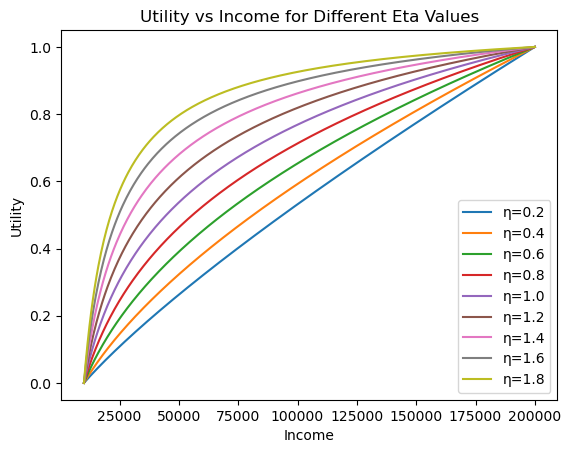

In [2]:
# Create a range of eta values and income values
eta_values = np.round(np.arange(0.2, 2, 0.2), decimals=1)
income = np.linspace(10000, 200000, 500)
# Plot each line with a different eta value
for eta in eta_values:
    utility_values = em.utility(consumption=income, eta=eta, normalize=True)
    sb.lineplot(x=income, y=utility_values, label=f'η={eta}')
# Add labels and title
plt.xlabel('Income')
plt.ylabel('Utility')
plt.title('Utility vs Income for Different Eta Values')
plt.legend()
# Show the plot
plt.show()

Assuming that the reconstruction process follows an exponential decay model, and that a household has recovered when 95% of the reconstruction is completed, we can estimate the time it takes for a household to recover. The time to recovery is calculated as follows:

$$
\tau = \ln\left(\frac{1}{1-0.95}\right) \lambda^{-1}
$$

The λ will describe the % that is recovered at each time step. So e.g., if λ = 0.05/year, it means that the household recovers 5% of the remaining reconstruction costs each year. Then the recovery time will be in years. 

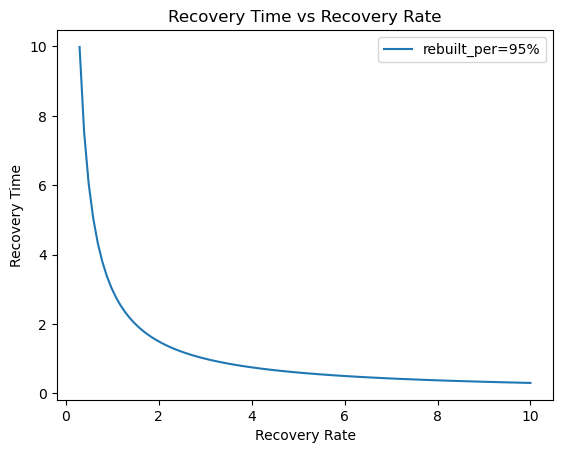

In [3]:
rates = np.linspace(0.3, 10, 100)
# Plot each line with a different eta value
recovery_times = em.recovery_time(rates)
sb.lineplot(x=rates, y=recovery_times, label='rebuilt_per=95%')
# Add labels and title
plt.xlabel('Recovery Rate')
plt.ylabel('Recovery Time')
plt.title('Recovery Time vs Recovery Rate')
plt.legend()

# Show the plot
plt.show()

Let's assume that we would like to calculate the well-being losses for a household in an arbitrary area over a recovery period of 10 years after a flood took place that damaged the building. Let's assume that the value of the building structure (**k_str**) is 30,000 USD and that the relative damage caused by the flood (**v**) was 70%.

In [4]:
t_max = 10 # recovery time considered in years
year_n = 52 # number of points we want to evaluate in a year
times = np.linspace(0, t_max, t_max * year_n) # time points
v = 0.4 # the loss ratio which is repair cost divided by the total building structure value
k_str = 200000 # building structure value

We can then calculate the reconstruction costs over time the '**reconstruction_cost_t**' function following the formula:
$$
c_{reco}(t) = \lambda \nu k^{str} e^{-\lambda t}
$$

The recovery rate describes how quickly the household will repair the building. The highest the value the quickest the household will recover. Here we test 3 different values of λ: 0.3, 0.4, and 0.5.

In [5]:
lambdas = [0.3, 0.4, 0.5] # recovery rates to test

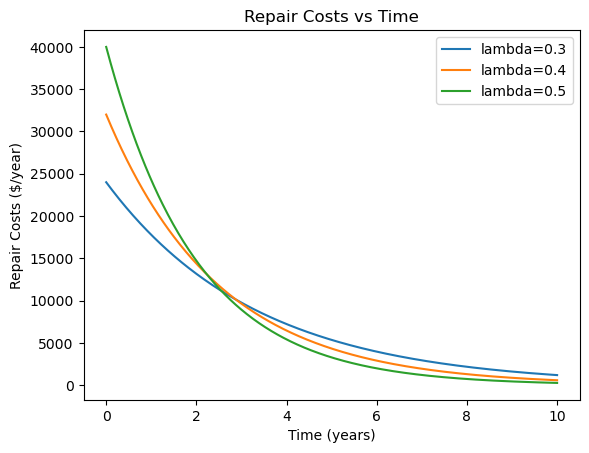

In [6]:
# Calculate repair costs for all combinations
repair_costs = [em.ReconstructionCost(t=times, l=_lambda, v=v, k_str=k_str) for _lambda in lambdas]
# Plot the repair costs
for i, _lambda in enumerate(lambdas):
    sb.lineplot(x=times, y=repair_costs[i].losses_t, label=f"lambda={_lambda}")
# Add labels and title
plt.xlabel('Time (years)')
plt.ylabel('Repair Costs ($/year)')
plt.title('Repair Costs vs Time')
plt.legend()

Besides the reconstruction costs a household will suffer income losses relative to the loss of capital as well. The capital in this cases is the value of the building and we use a the productivity of capital index π to calculate the income losses. The income losses are calculated as follows:
$$
\Delta i (t) = \pi \nu k^{str} e^{-\lambda t}
$$


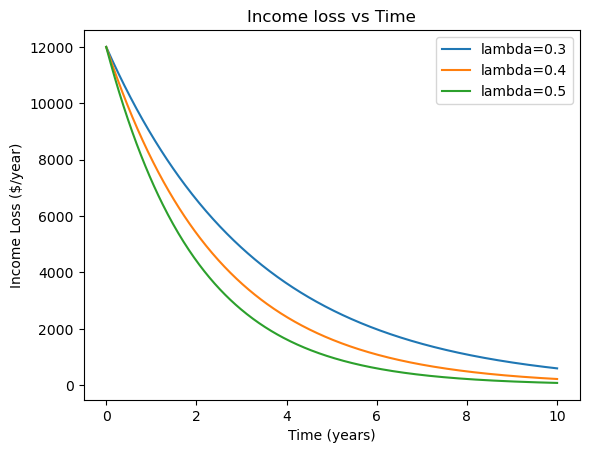

In [7]:
pi = 0.15 # productivity of capital index
# Calculate income loss for each lambda value and plot
for _lambda in lambdas:
    income_loss = em.IncomeLoss(t=times, l=_lambda, v=v, k_str=k_str, pi=pi)
    sb.lineplot(x=times, y=income_loss.losses_t, label=f"lambda={_lambda}")
# Add labels and title
plt.xlabel('Time (years)')
plt.ylabel('Income Loss ($/year)')
plt.title('Income loss vs Time')
plt.legend()


Then we can calculate the consumption losses over time by simply adding up the reconstruction costs and the income losses:

$$
\Delta c (t) = c_{reco}(t) + \Delta i (t)
$$

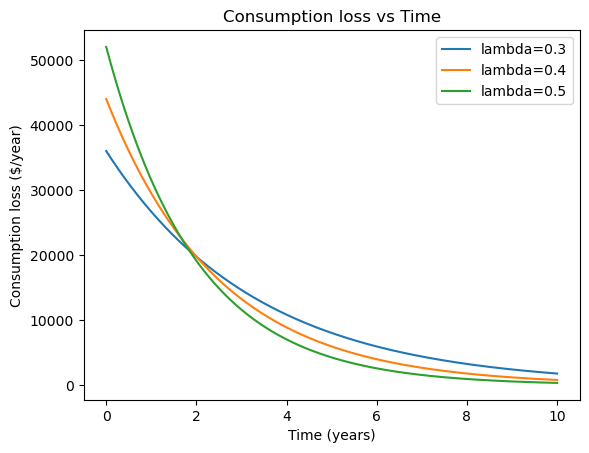

In [ ]:
# Plot the consumption loss
for _lambda in lambdas:
    consumption_loss = em.ConsumptionLoss(t=times, l=_lambda, v=v, k_str=k_str, pi=pi)
    line = sb.lineplot(x=times, y=consumption_loss.losses_t, label=f"lambda={_lambda}")

# Add labels and title
plt.xlabel('Time (years)')
plt.ylabel('Consumption loss ($/year)')
plt.title('Consumption loss vs Time')
plt.legend()

To calculate the optimal recovery rate for a household we can assume that the household will try to minimize the utility losses over the recovery period. We can calculate the utility losses with the UtilityLoss class, which has the losses_t attribute. For these calculations we need the yearly income of the household and the elasticity of the marginal utility of consumption. Then we can try different recovery rates and calculate the total utility losses for each of them. The optimal recovery rate is the one that minimizes the total utility losses.

In [14]:
c0 = 60000 # yearly income
eta = 1.5 # elasticity of the marginal utility
savings = 0 # For now zero
# Define time range for recovery rates
t_min = 1/12
t_max = 10 # recovery time considered in years
year_n = 52 # how many points we want to evaluate in a year
times = np.linspace(0, t_max, t_max * year_n) # time series to calculate utility loss rates
# Define a range of lambda values to test
rec_times_test = np.linspace(t_min, t_max, 100)
_lambdas_test = em.recovery_rate(rec_times_test)

# Calculate utility loss and consumption loss for each lambda value
u_loss, c_loss = [], []
for _lambda in _lambdas_test:
    u_loss.append(em.UtilityLoss(times, _lambda, v=v, k_str=k_str, pi=pi, c0=c0, eta=eta, savings=savings))
    c_loss.append(em.ConsumptionLoss(times, _lambda, v=v, k_str=k_str, pi=pi, savings=savings))

# Store info
c_loss_t_l = np.array([c.losses_t for c in c_loss])
u_loss_l = np.array([u.total(rho=0, method="trapezoid") for u in u_loss])

# Find the lambda value corresponding to the minimum utility loss
min_dw_index = np.nanargmin(u_loss_l)
min_lambda = _lambdas_test[min_dw_index]

Now we can plot all these information to visualize the utility losses and the consumption losses over time for different recovery rates. In the left graph you can see the consumption losses over time for different recovery rates. The red hatch indicates times that the consumption needed is higher than the income of the household, meaning that this recovery rates are not feasible. In the right graph you can see the total utility losses for each recovery rate. The optimal recovery rate is the one that minimizes the total utility losses.

C:\Users\athanasi\AppData\Local\Temp\ipykernel_56780\2958498897.py:21: UserWarning: linewidths is ignored by contourf
  ax1.contourf(


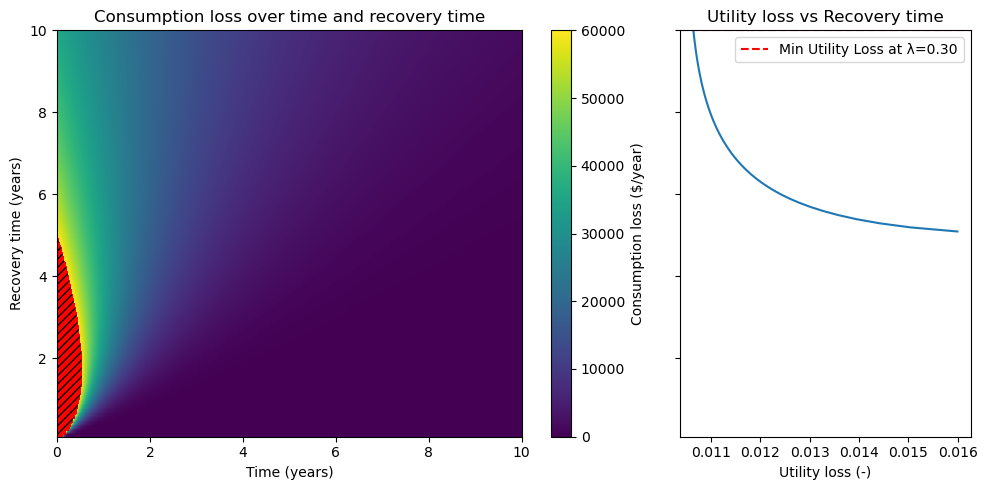

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True, width_ratios=[2, 1])

# First plot: image plot as before
masked_u_loss_t = np.ma.masked_invalid(c_loss_t_l)
im = ax1.imshow(
    masked_u_loss_t,
    aspect='auto',
    origin='lower',  # Flip the y-axis so the plot is upside down
    cmap='viridis',
    vmax=c0,
    extent=[times[0], times[-1], t_min, t_max]
)
ax1.set_xlabel('Time (years)')
ax1.set_ylabel('Recovery time (years)')
ax1.set_title('Consumption loss over time and recovery time')
fig.colorbar(im, ax=ax1, label='Consumption loss ($/year)')

# Overlay hatched mask where values > c0
hatch_mask = c_loss_t_l > c0
X, Y = np.meshgrid(times, rec_times_test)
ax1.contourf(
    X, Y, hatch_mask,
    levels=[0.5, 1],
    colors='red',
    hatches=['////'],
    linewidths=0
)

# Second plot: utility loss vs lambda (reversed y-axis)
ax2.plot(u_loss_l, rec_times_test)
ax2.axhline(y= em.recovery_time(min_lambda), color='r', linestyle='--', label=f'Min Utility Loss at λ={min_lambda:.2f}')
ax2.set_xlabel('Utility loss (-)')
ax2.set_title('Utility loss vs Recovery time')
ax2.legend()

plt.tight_layout()
plt.show()

The `opt_lambda` method perform this calculations and returns the optimal lambda value. There are two methods to calculate the total loss. 

- The "trapezoid" method, which calculates the integral based on the trapezoid rule, using the numpy package (faster but accurate only for small enough time steps)
- The "quad" method, which calculates the integral based on the adaptive quadrature algorithm, using the scipy package (slower but not dependent on time step)

The "opt_lambda" method can be used directly to find the optimum lambda. Here is a comparison of the trapezoid and quad methods for the same example.

In [15]:
import time
start_time = time.time()
optimal_lambda = em.opt_lambda(v, k_str, c0, pi, eta, times=times, l_min=_lambdas_test[-1], l_max=_lambdas_test[0], method="trapezoid", savings=savings)
end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")
print(f"Optimal lambda: {optimal_lambda['l_opt_min']}")

Time taken: 0.0009984970092773438 seconds
Optimal lambda: 0.299573227355399


In [16]:
start_time = time.time()
optimal_lambda = em.opt_lambda(v, k_str, c0, pi, eta, t_max=t_max, l_min=_lambdas_test[-1], l_max=_lambdas_test[0], method="quad", savings=savings)
end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")
print(f"Optimal lambda: {optimal_lambda['l_opt_min']}")

Time taken: 0.004996538162231445 seconds
Optimal lambda: 0.299573227355399
